# Import Libraries and Clone Github

In [1]:
# Import Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata

In [2]:
# Import github token with google secrets thingy and clone git repository
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/Financial_Sentiment_LLM.git

Cloning into 'Financial_Sentiment_LLM'...
remote: Enumerating objects: 1764, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 1764 (delta 99), reused 104 (delta 57), pack-reused 1595
Receiving objects: 100% (1764/1764), 356.00 MiB | 9.92 MiB/s, done.
Resolving deltas: 100% (1182/1182), done.
Updating files: 100% (1111/1111), done.


In [3]:
sentiment_df = pd.read_csv('/content/Financial_Sentiment_LLM/03_Sentiment_Analysis/Sentiment_Analysis_Results.csv')
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'], errors='coerce')
display(sentiment_df.head())

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves / Exploration / Acquisitions / Mergers / Divestments,Environment / Regulatory / Geopolitics,Alternative Energy / Lower Carbon,Oil Price / Natural Gas Price / Gasoline Price
0,Investment Research,IR-1,MRO,2024-05-16,NaN,Positive,Neutral,Positive,Negative,Neutral,Neutral
1,Investment Research,IR-2,EOG,2024-05-14,NaN,Positive,Neutral,Positive,Neutral,Positive,Neutral
2,Investment Research,IR-3,EOG,2024-05-11,NaN,Positive,Positive,Positive,Neutral,Neutral,Neutral
3,Investment Research,IR-4,DVN,2024-05-11,NaN,Positive,Neutral,Positive,Negative,Neutral,Neutral
4,Investment Research,IR-5,COP,2024-05-07,NaN,Positive,Neutral,Neutral,Negative,Neutral,Neutral


# Visualize Results

In [4]:
# Count of rows with all neutral for each source
sentiment_columns = [
    'Finance',
    'Production',
    'Reserves / Exploration / Acquisitions / Mergers / Divestments',
    'Environment / Regulatory / Geopolitics',
    'Alternative Energy / Lower Carbon',
    'Oil Price / Natural Gas Price / Gasoline Price']

# Filter rows where all sentiment columns are 'Neutral'
neutral_df = sentiment_df[(sentiment_df[sentiment_columns] == 'Neutral').all(axis=1)]

# Count rows per source
neutral_counts = neutral_df['Source'].value_counts().reset_index()
neutral_counts.columns = ['Source', 'Neutral_Counts']

display(neutral_counts)

,Source,Neutral_Counts
0,Investment Research,112
1,ProQuest,38


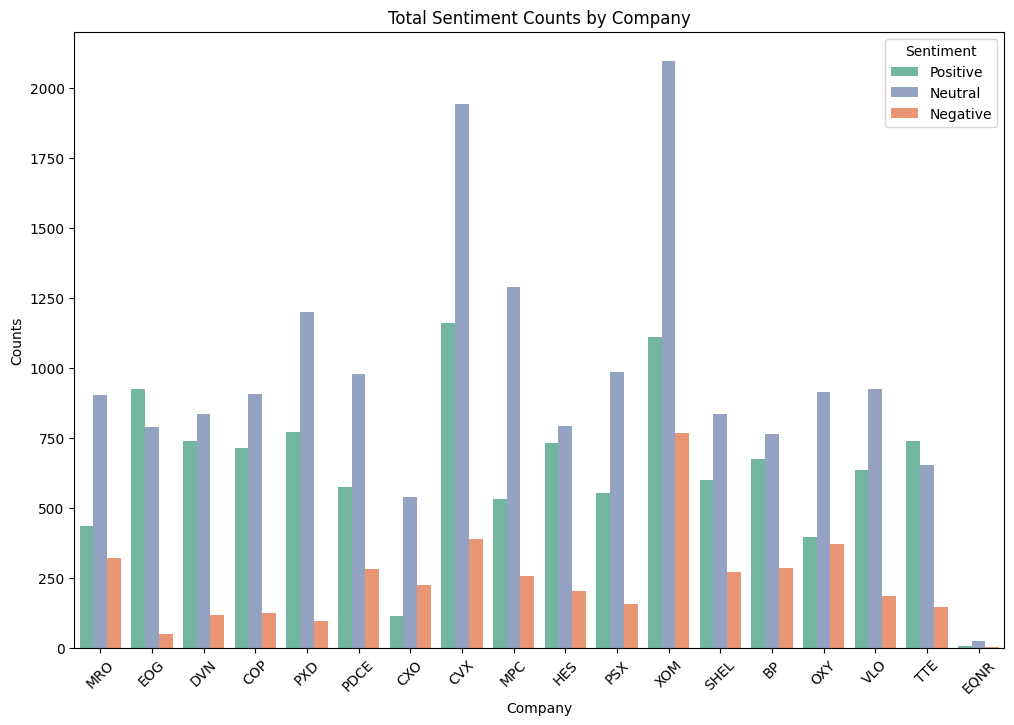

In [5]:
# Plot sentiment counts by company
# Melt the DataFrame to combine all sentiment columns into one
melted_df = sentiment_df.melt(id_vars=['Source', 'Ticker', 'Date'], value_vars=sentiment_columns,
                              var_name='Sentiment_Category', value_name='Sentiment')

# Define the color palette
palette = {'Positive': '#66c2a5', 'Neutral': '#8da0cb', 'Negative': '#fc8d62'}

# Group by company and sentiment, then count the occurrences
grouped_df = melted_df.groupby(['Ticker', 'Sentiment']).size().reset_index(name='Counts')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

sns.countplot(data=melted_df, x='Ticker', hue='Sentiment', palette=palette, ax=ax)
ax.set_title('Total Sentiment Counts by Company')
ax.set_xlabel('Company')
ax.set_ylabel('Counts')
ax.tick_params(axis='x', rotation=45)

plt.show()

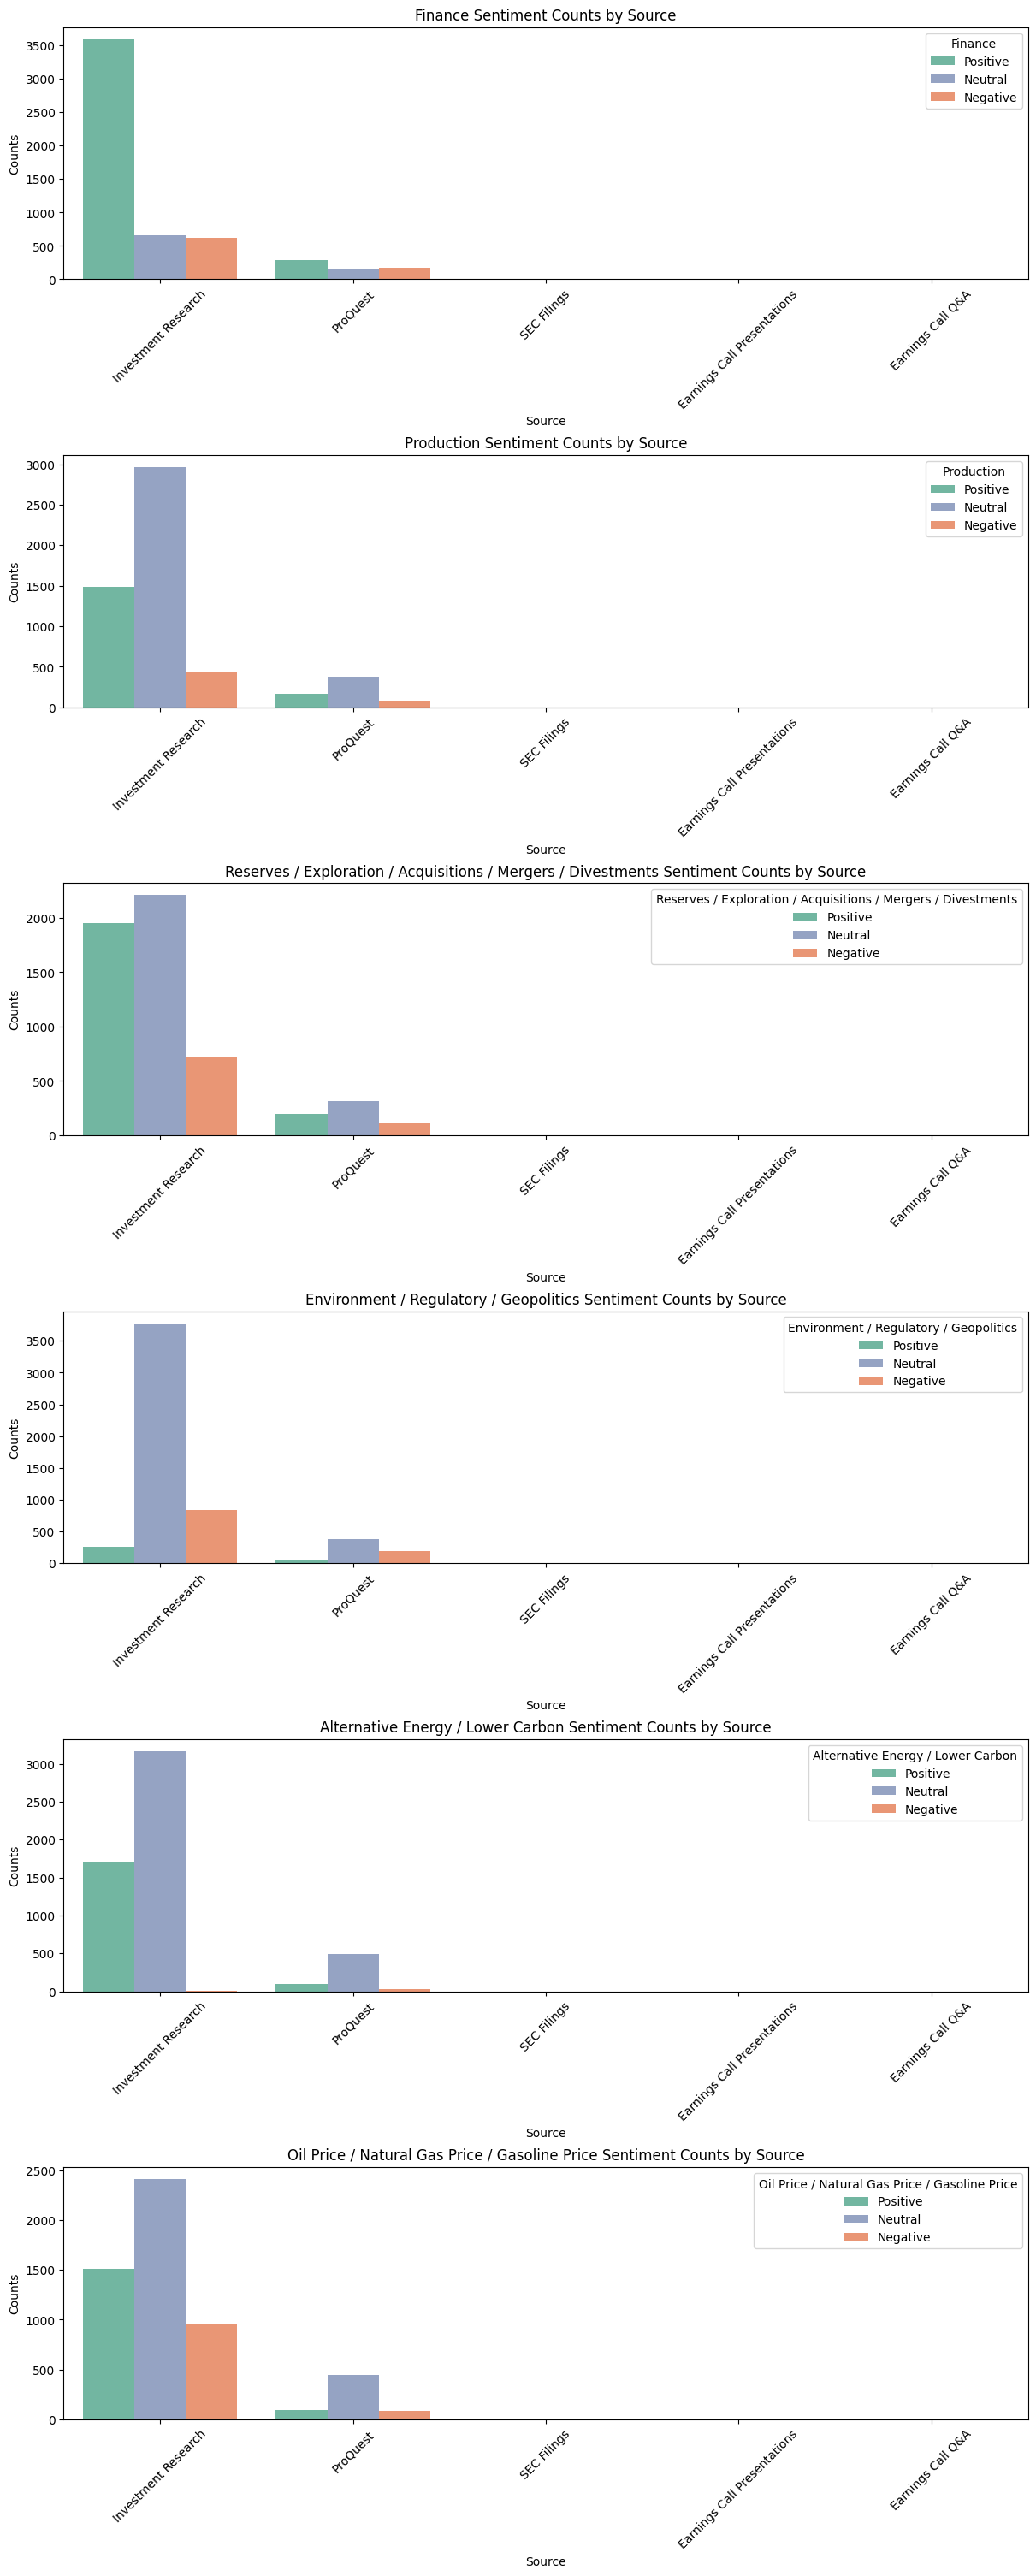

In [6]:
# Plot sentiment counts by category

# Define the color palette
palette = {'Positive': '#66c2a5', 'Neutral': '#8da0cb', 'Negative': '#fc8d62'}
hue_order = ['Positive', 'Neutral', 'Negative']

# Create subplots
fig, axes = plt.subplots(nrows=len(sentiment_columns), ncols=1, figsize=(12, len(sentiment_columns) * 5), constrained_layout=True)

# Plot each sentiment category
for i, column in enumerate(sentiment_columns):
    sns.countplot(data=sentiment_df, x='Source', hue=column, ax=axes[i], palette=palette, hue_order=hue_order)
    axes[i].set_title(f'{column} Sentiment Counts by Source')
    axes[i].set_xlabel('Source')
    axes[i].set_ylabel('Counts')
    axes[i].tick_params(axis='x', rotation=45)

plt.show()

### For comparison:
Example Output:
- Finance - Positive
- Production - Neutral
- Reserves / Exploration / Acquisitions / Mergers / Divestments - Negative
- Environment / Regulatory / Geopolitics - Neutral
- Alternative Energy / Lower Carbon - Positive
- Oil Price / Natural Gas Price / Gasoline Price - Neutral

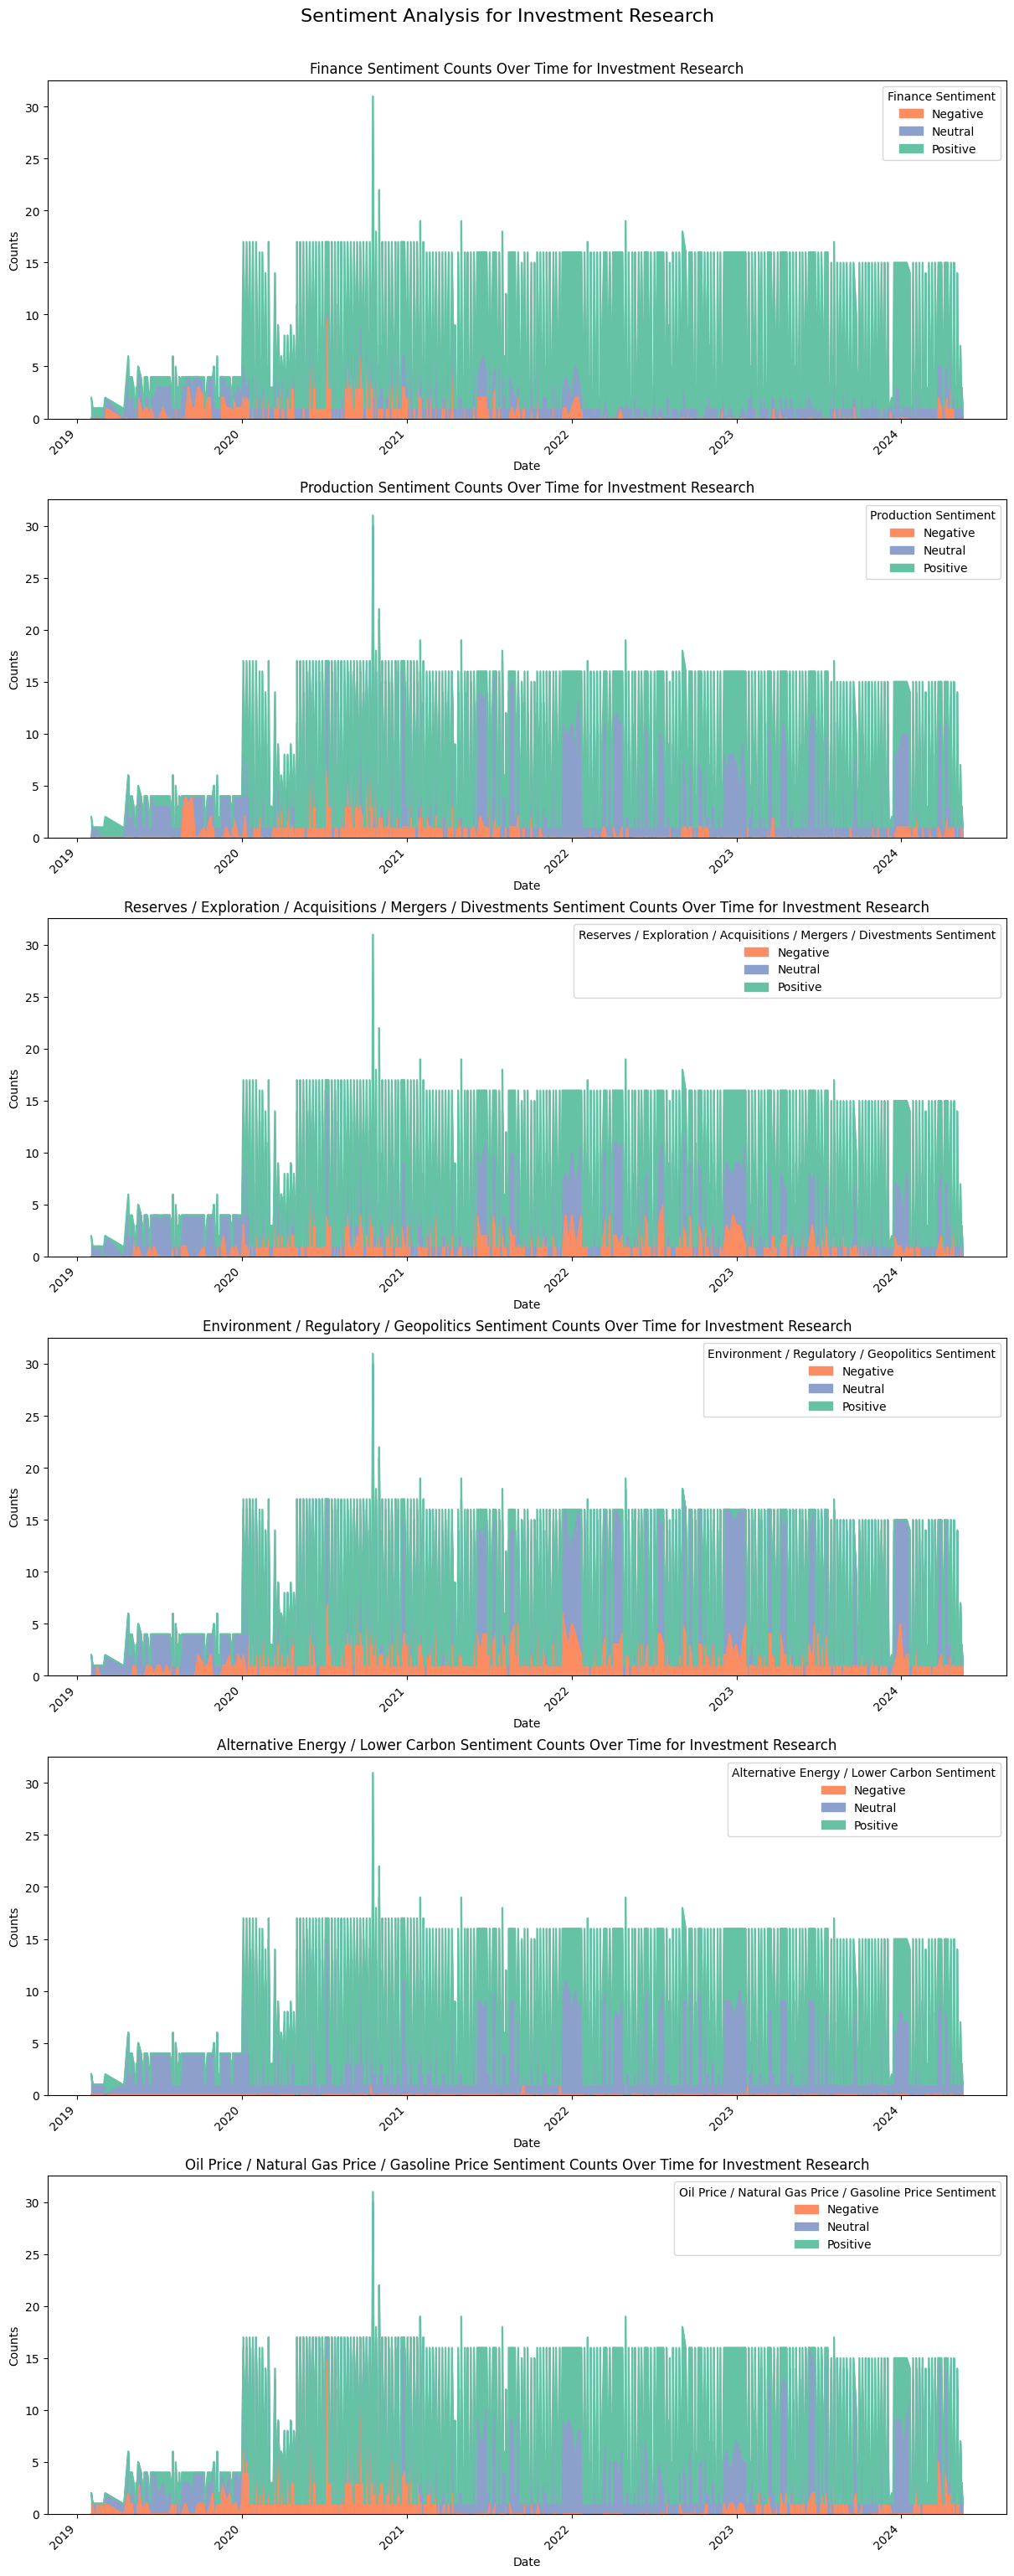

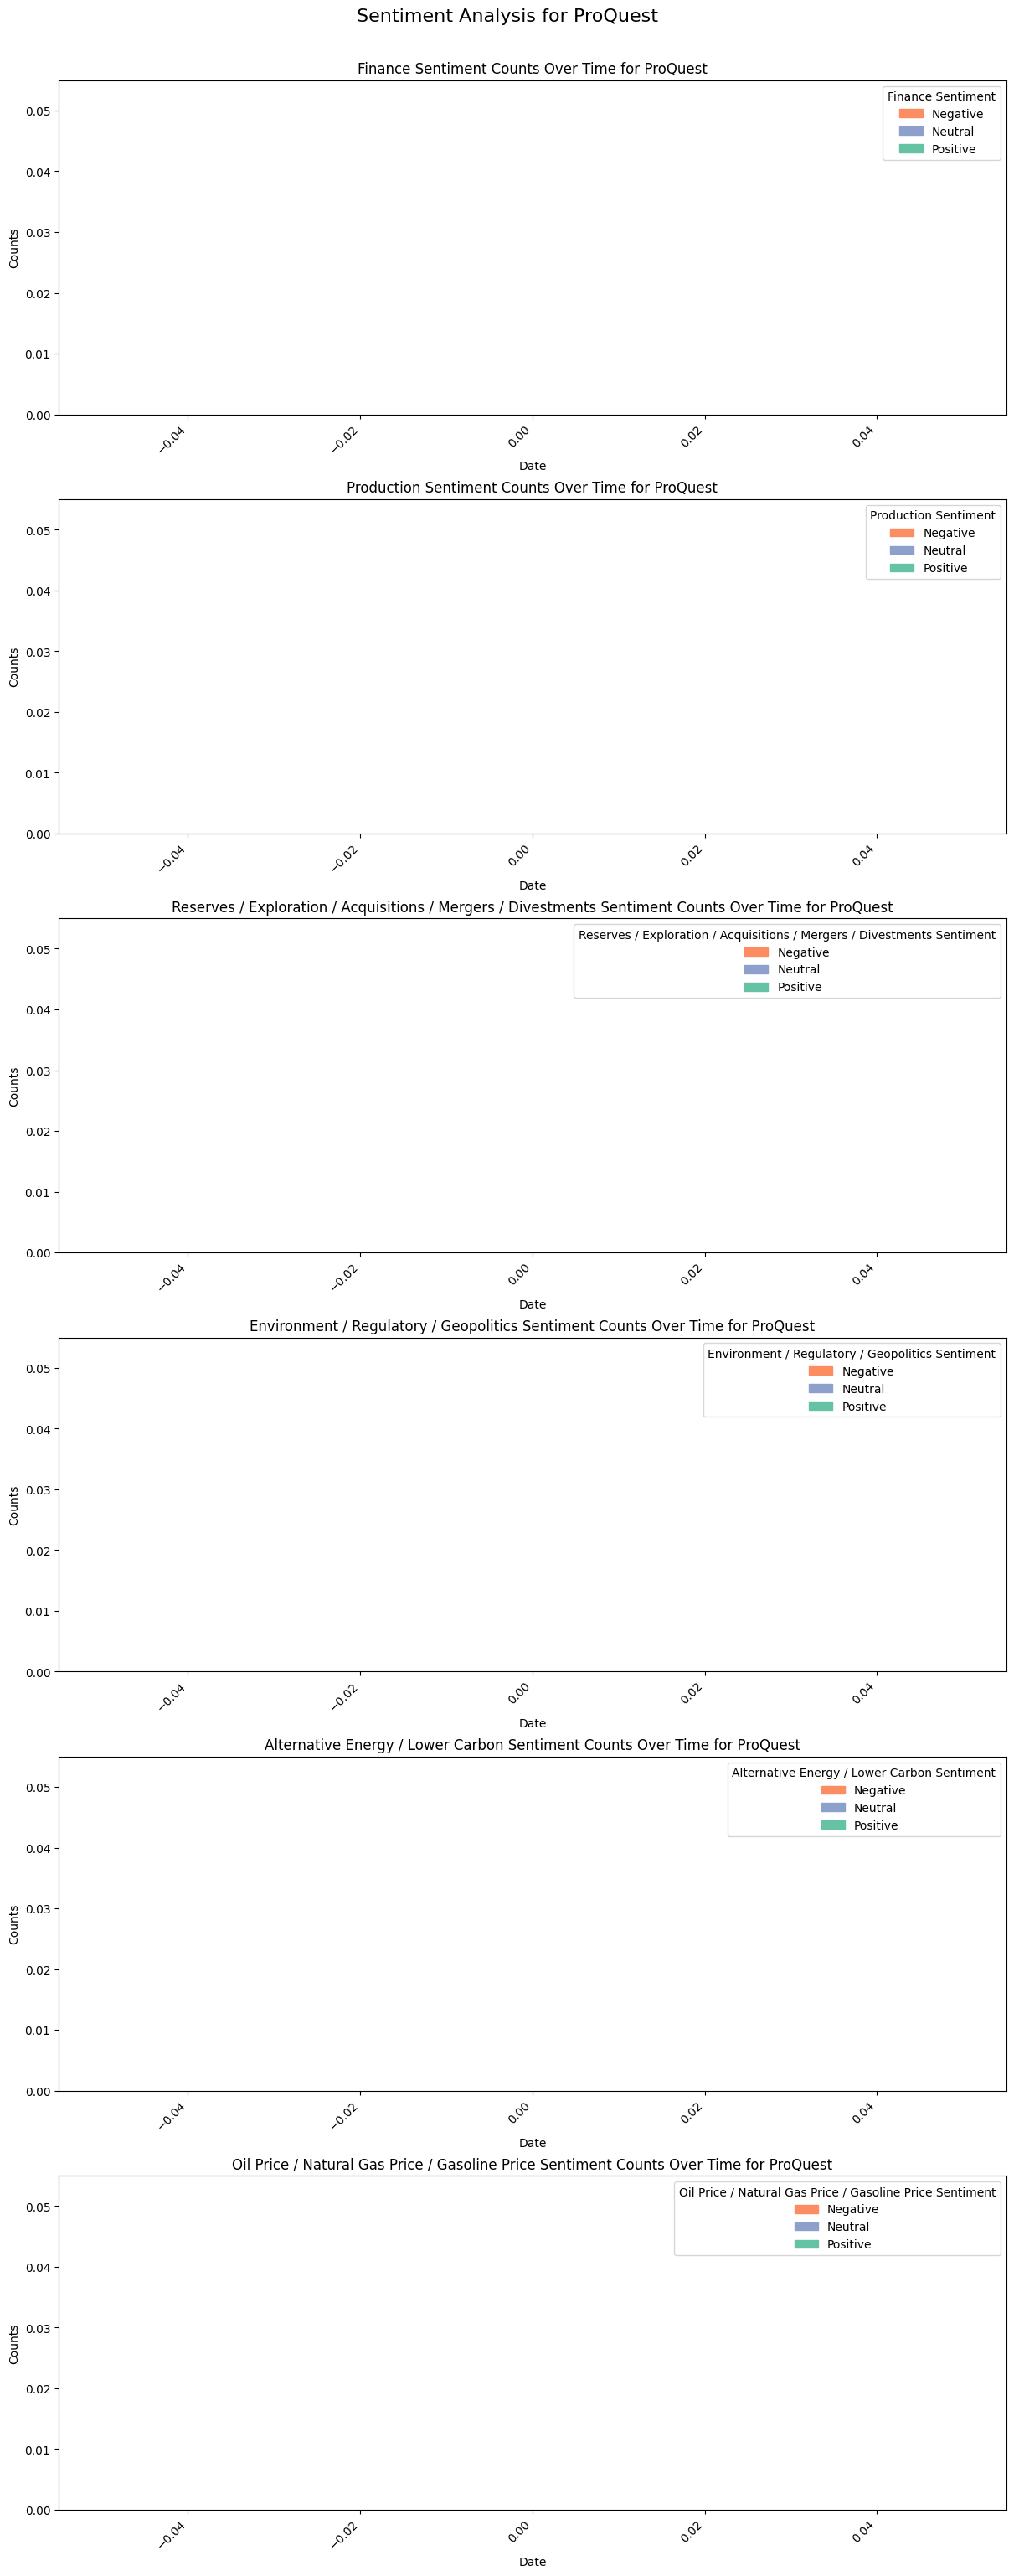

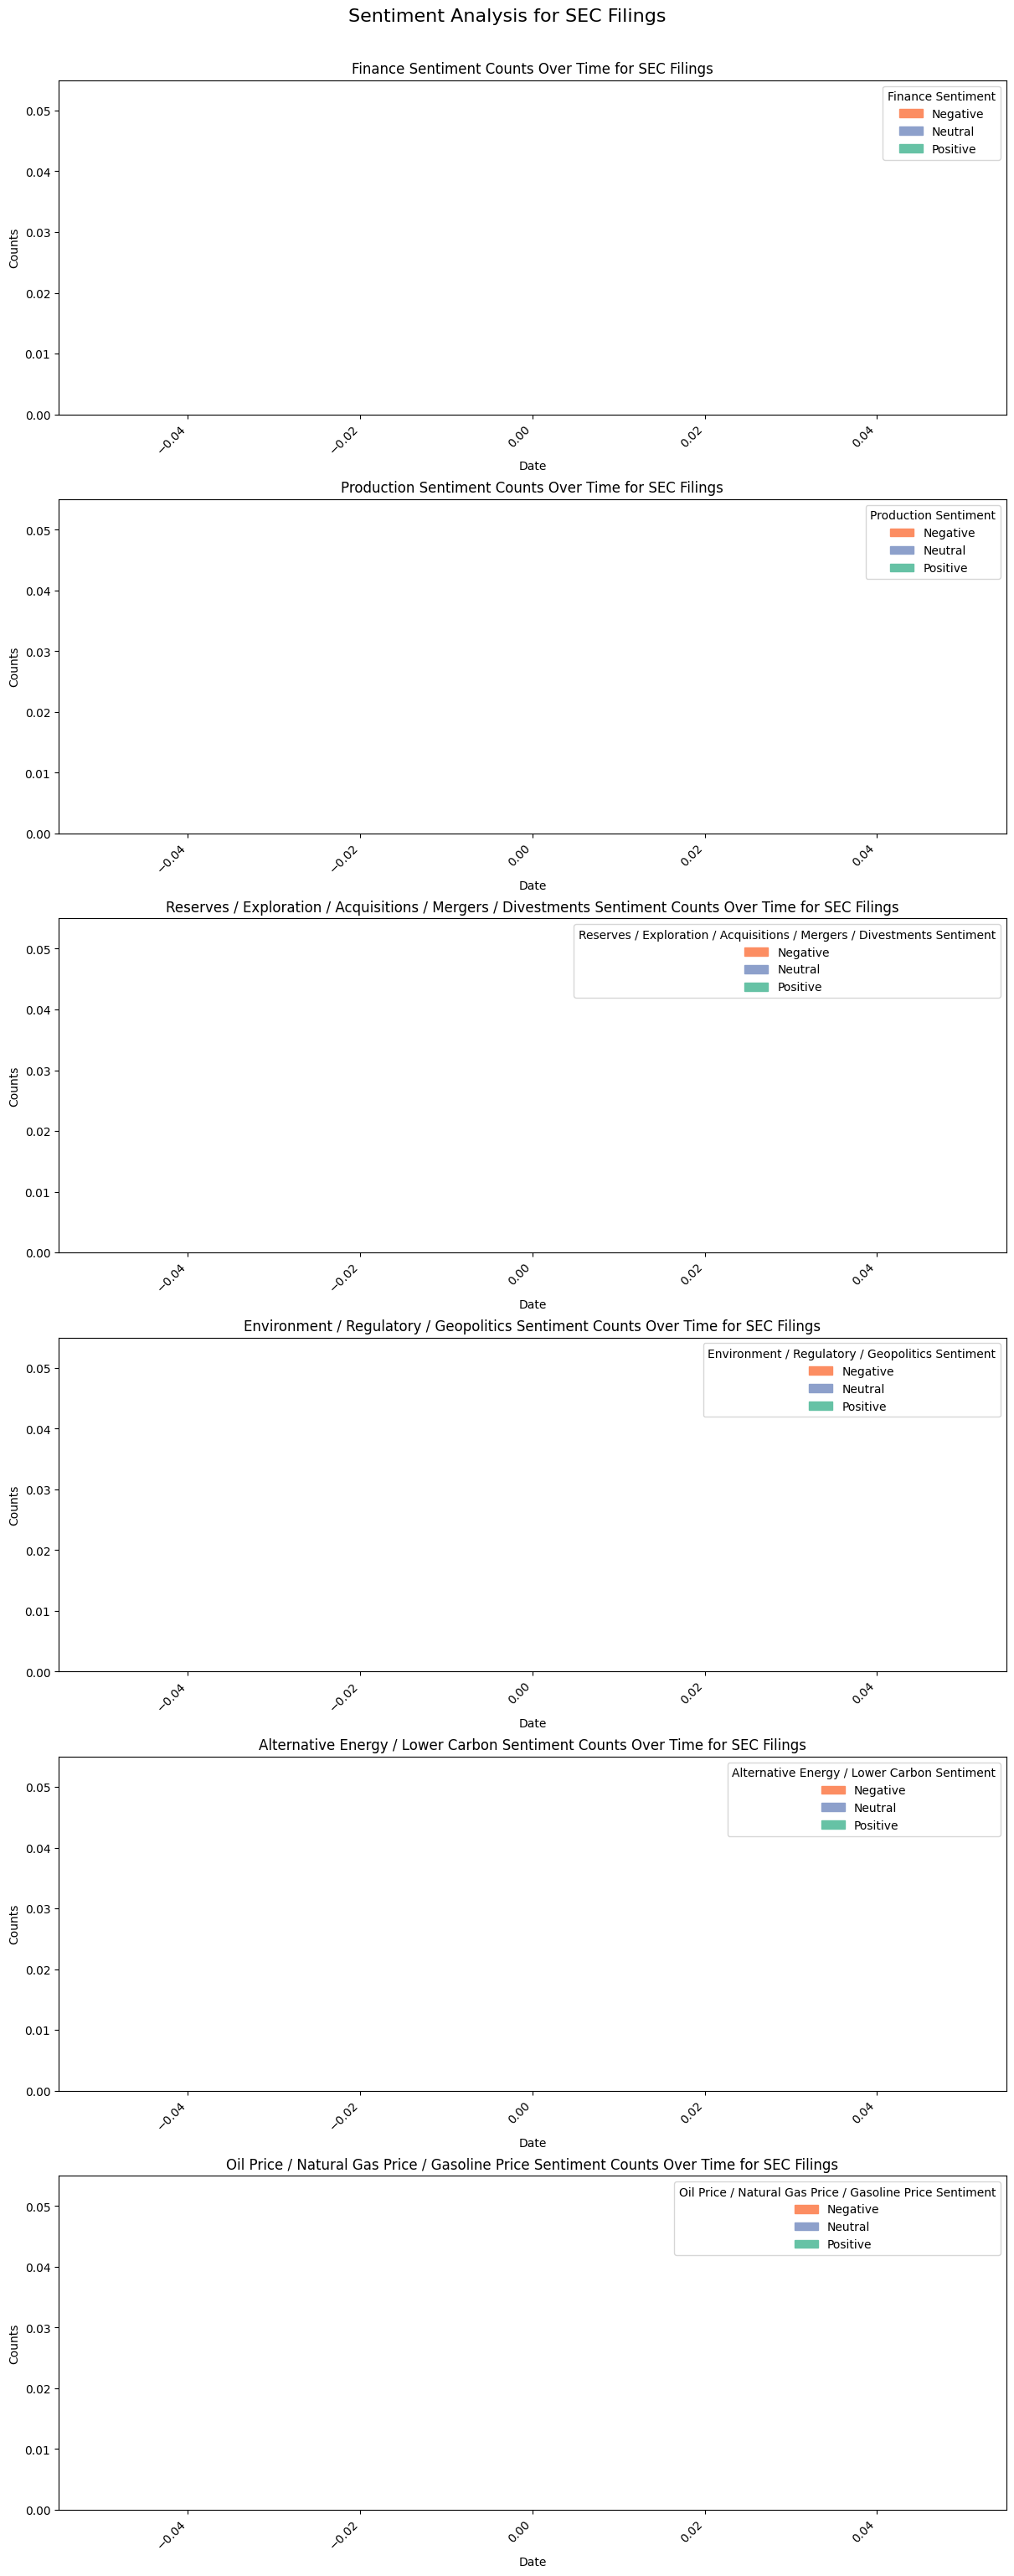

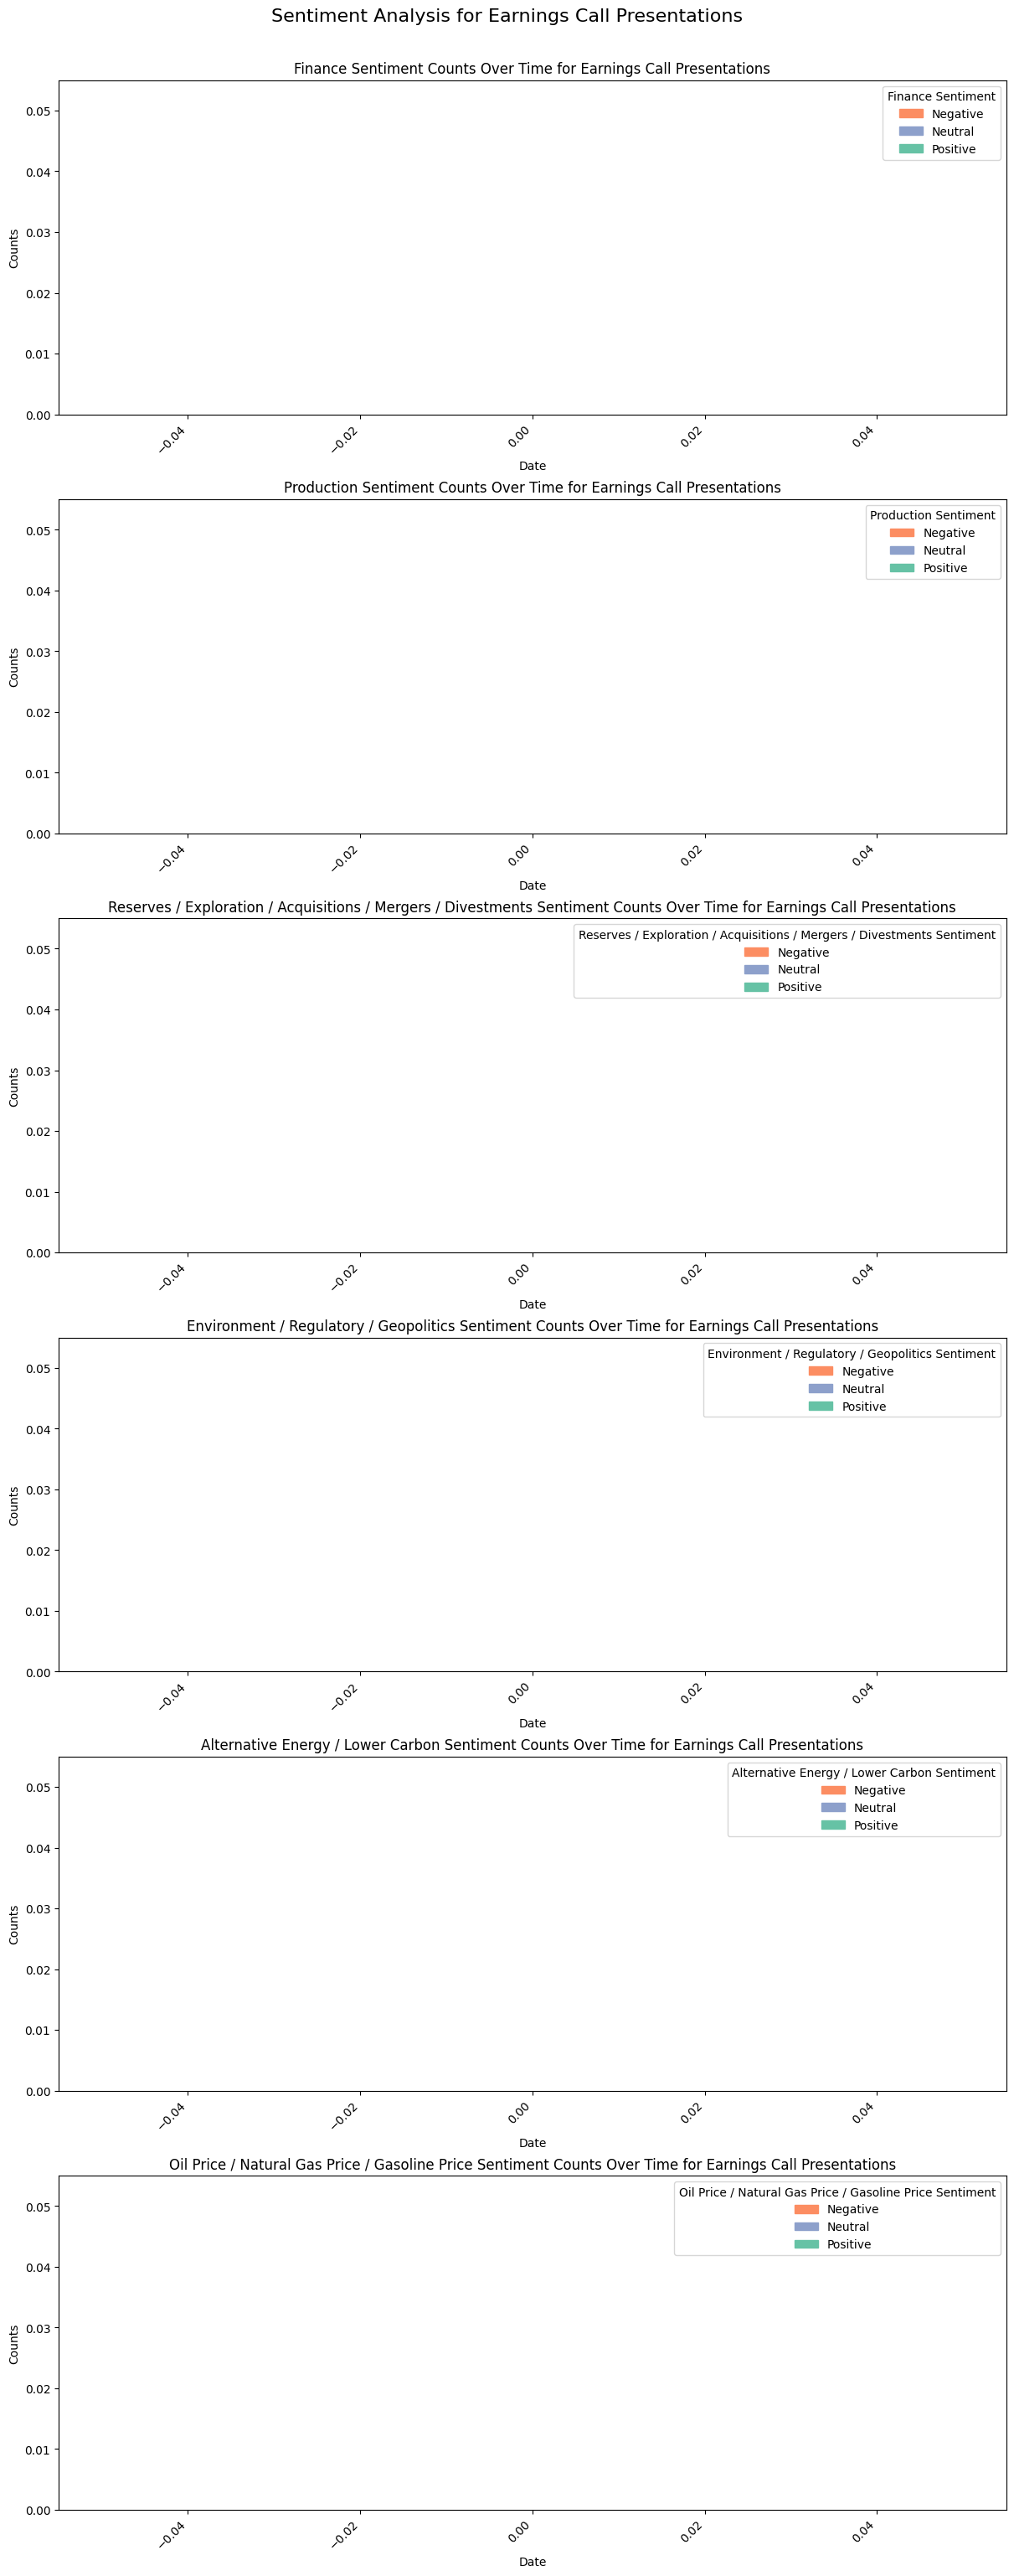

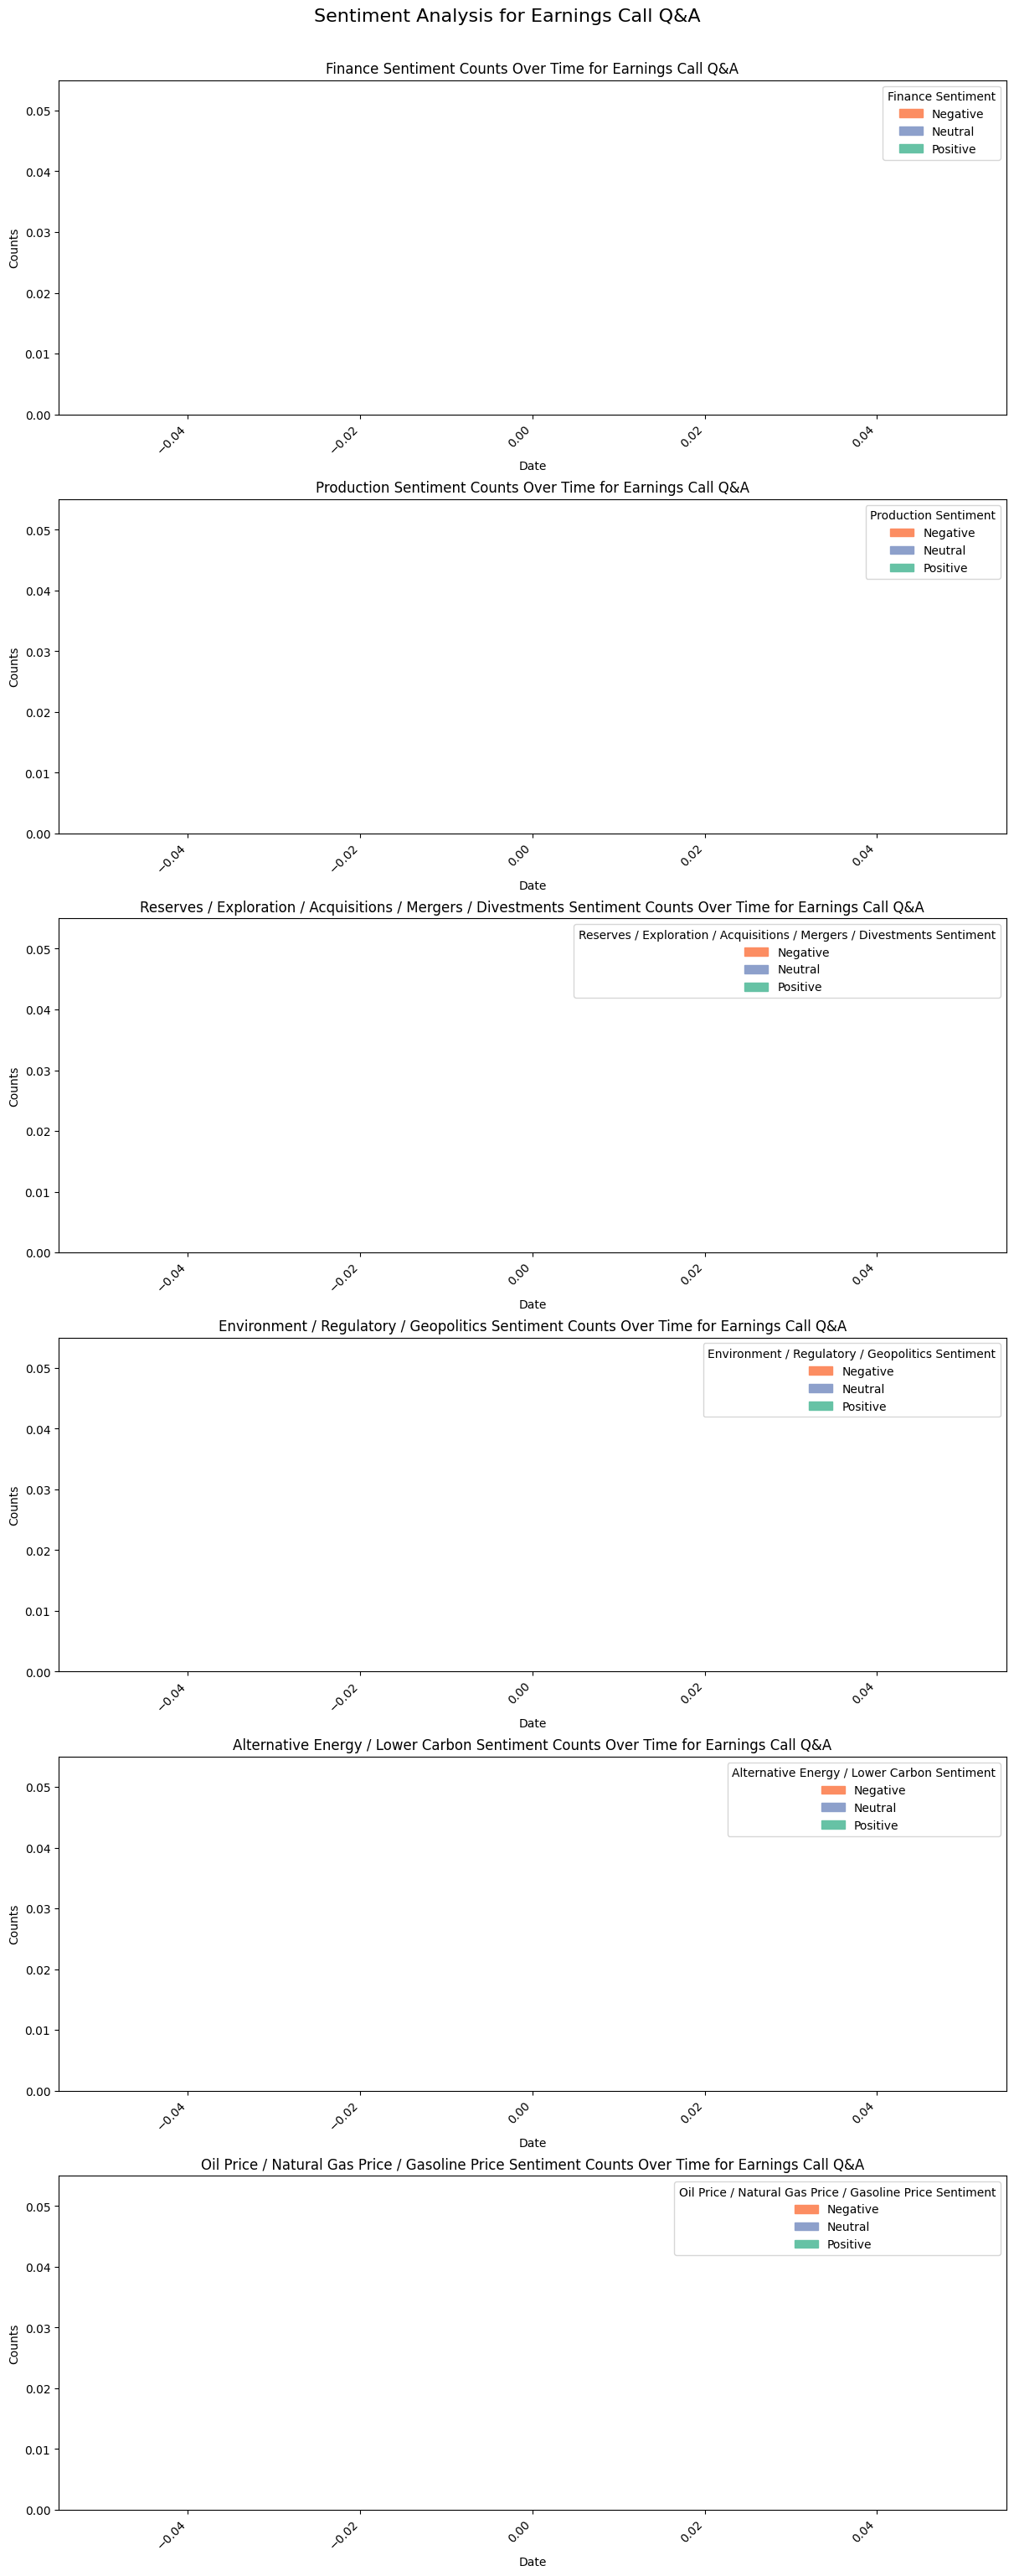

In [7]:
# Plot sentiment over time
sources = sentiment_df['Source'].unique()

# Define the order and palette for the sentiments
palette = {'Positive': '#66c2a5', 'Neutral': '#8da0cb', 'Negative': '#fc8d62'}
hue_order = ['Negative', 'Neutral', 'Positive']

# Loop through each source and plot the sentiment counts over time
sources = sentiment_df['Source'].unique()
for source in sources:
    source_df = sentiment_df[sentiment_df['Source'] == source]

    # Create subplots
    fig, axes = plt.subplots(nrows=len(sentiment_columns), ncols=1, figsize=(12, len(sentiment_columns) * 5), constrained_layout=True)

    # Plot each sentiment category over time using stacked area plot
    for i, column in enumerate(sentiment_columns):
        df_melted = source_df.melt(id_vars=['Date'], value_vars=[column], var_name='Sentiment_Type', value_name='Sentiment')
        df_grouped = df_melted.groupby(['Date', 'Sentiment']).size().reset_index(name='Counts')
        df_pivot = df_grouped.pivot(index='Date', columns='Sentiment', values='Counts').fillna(0)

        # Ensure all sentiments are present
        for sentiment in hue_order:
            if sentiment not in df_pivot.columns:
                df_pivot[sentiment] = 0

        # Reorder columns to match hue_order
        df_pivot = df_pivot[hue_order]

        df_pivot.plot(kind='area', stacked=True, ax=axes[i], color=[palette[sent] for sent in hue_order])
        axes[i].set_title(f'{column} Sentiment Counts Over Time for {source}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Counts')
        axes[i].legend(title=f'{column} Sentiment')
        axes[i].tick_params(axis='x', rotation=45)

    # Show the plot for the current source
    plt.suptitle(f'Sentiment Analysis for {source}', y=1.02, fontsize=16)
    plt.show()